# P8 - Déployer un modèle dans le cloud

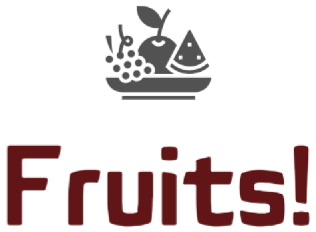

# P8_01_02 - CLOUD - Utilisation de AWS

Ce notebook traite de du chargement du jeu de données des images, du pré-processing, de la réduction de dimension et d'une mini classification pour des nouvelles images en utilisant l'outils **AWS** pour la partie "**compute**" (calculs distribués) et un **container de stockage S3** "**EKS**" pour l'orchestration.

## 1. Introduction

*****
**Mission**
*****
**Développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension** pour une startup Fruits! de l'AgriTech pour mettre à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

*****
**Contraintes**
*****
- Le volume de données va augmenter très rapidement après la livraison de ce projet.
- Développer des scripts en Pyspark.
- Utiliser le cloud AWS ou autre (Microsoft Azure sera utilisé pour ce projet) pour profiter d’une architecture Big Data. 

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/moltean/fruits) : constitué des images de fruits et des labels associés, qui pourra servir de point de départ pour construire une partie de la chaîne de traitement des données.

**Information sur le jeu de données :**
***

- Nombre **total d'images** : **90483**.
- Jeu de données **train set** : **67692** images (1 fruit ou 1 légumes par image).
- Jeu de données **test set** : **22688**  images (1 fruit ou 1 légumes par image).
- Nombre de **classes** : 131 (fruits ou légumes).
- **Taille** des images : 100x100 pixels.
- **Format du nom de fichier** : 
  - **imageindex100.jpg** (par exemple 32100.jpg),
  - ou **rimageindex100.jpg** (par exemple r32100.jpg),
  - ou **r2imageindex100.jpg**,
  - ou **r3imageindex100.jpg**. 
     - ou "r" signifie que le fruit a subi une rotation,
     - "r2" signifie que le fruit a été tourné autour du 3ème axe,
     - "100" vient de la taille de l'image (100x100 pixels).
- Exemples de classe : Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red, Lady Finger), Beetroot Red, Blueberry, Cactus fruit, Cantaloupe (2 varieties), Carambula, Cauliflower, Cherry (different varieties, Rainier), Cherry Wax (Yellow, Red, Black), Chestnut, Clementine, Cocos, Corn (with husk), Cucumber (ripened), Dates, Eggplant, Fig, Ginger Root, Granadilla, Grape (Blue, Pink, White (different varieties)), Grapefruit (Pink, White), Guava, Hazelnut, Huckleberry, Kiwi, Kaki, Kohlrabi, Kumsquats, Lemon (normal, Meyer), Lime, Lychee, Mandarine, Mango (Green, Red), Mangostan, Maracuja, Melon Piel de Sapo, Mulberry, Nectarine (Regular, Flat), Nut (Forest, Pecan), Onion (Red, White), Orange, Papaya, Passion fruit, Peach (different varieties), Pepino, Pear (different varieties, Abate, Forelle, Kaiser, Monster, Red, Stone, Williams), Pepper (Red, Green, Orange, Yellow), Physalis (normal, with Husk), Pineapple (normal, Mini), Pitahaya Red, Plum (different varieties), Pomegranate, Pomelo Sweetie, Potato (Red, Sweet, White), Quince, Rambutan, Raspberry, Redcurrant, Salak, Strawberry (normal, Wedge), Tamarillo, Tangelo, Tomato (different varieties, Maroon, Cherry Red, Yellow, not ripened, Heart), Walnut, Watermelon.

In [ ]:
# import os
# import sys
# spark_home = os.environ.get('SPARK_HOME', None)

# sys.path.insert(0, os.path.join(spark_home, 'python'))
# sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.9.5-src.zip'))

In [1]:
import findspark
findspark.init()

In [4]:
# Chargement des librairies
import os
import sys
import datetime
import io
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import datetime
import pandas as pd
import numpy as np
from typing import Iterator
# Visualisation
import matplotlib
import matplotlib.pyplot as plt

# Pyspark
import pyspark
from pyspark.sql.functions import element_at, split, col, pandas_udf, PandasUDFType, udf
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession

# Tensorflow Keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Gestion des images
import PIL
from PIL import Image

# Taches ML
from pyspark.ml.image import ImageSchema

# Réduction de dimension - PCA
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Modélisation
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Matrice de confusion

from pyspark.mllib.evaluation import MulticlassMetrics
import itertools

%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('tensorflow    : ' + tf.__version__)
print('pyspark       : ' + pyspark.__version__)
print('PIL           : ' + PIL.__version__)
print('Numpy         : ' + np.__version__)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + matplotlib.__version__)
now = datetime.now().isoformat()
print('Lancé le      : ' + now)

Version des librairies utilisées :
Python        : 3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]
tensorflow    : 2.11.0
pyspark       : 3.3.1
PIL           : 9.4.0
Numpy         : 1.24.2
Pandas        : 1.5.3
Matplotlib    : 3.7.0
Lancé le      : 2023-02-23T11:26:47.899292


## 2. Préparation des données du train set

### 2.1. Jeu de données train set - au format "binaryFile"

#### 2.2.1. Connection au bucket s3

In [6]:
## Define the details of the SparkSession

spark = SparkSession.builder.appName('FeatExtraction').getOrCreate()
sc = spark.sparkContext.getOrCreate()
hadoopConf = sc._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.access.key", os.getenv('aws_key'))
hadoopConf.set("fs.s3a.secret.key", os.getenv('aws_secret'))
hadoopConf.set("spark.jars.ivy","/tmp/.ivy") 
hadoopConf.set("spark.sql.execution.arrow.maxRecordsPerBatch","1024") 
hadoopConf.set("--conf spark.dynamicAllocation.enabled","true ") 
hadoopConf.set("spark.dynamicAllocation.shuffleTracking.enabled","true")  
hadoopConf.set("spark.dynamicAllocation.shuffleTracking.timeout","600 ") 
hadoopConf.set("spark.dynamicAllocation.minExecutors","2") 
hadoopConf.set("spark.dynamicAllocation.maxExecutors","2") 
hadoopConf.set("spark.kubernetes.allocation.batch.size","10")  
hadoopConf.set("spark.dynamicAllocation.executorAllocationRatio","1")  
hadoopConf.set("spark.dynamicAllocation.schedulerBacklogTimeout","1")  
hadoopConf.set("spark.driver.memory","20G")
hadoopConf.set("spark.executor.memory","5G")  
hadoopConf.set("spark.executor.cores","2")  
hadoopConf.set("spark.sql.shuffle.partitions","16")  
hadoopConf.set("spark.hadoop.mapreduce.outputcommitter.factory.scheme.s3a","org.apache.hadoop.fs.s3a.commit.S3ACommitterFactory") 
hadoopConf.set("spark.sql.sources.commitProtocolClass","org.apache.spark.internal.io.cloud.PathOutputCommitProtocol") 


#### 2.2.2. Chargement du jeu de données train set - au format "binaryFile"

**Recommandation databricks** : 

Databricks recommande d’utiliser la source de données de fichier binaire pour charger des données d’image dans le tableau Spark en tant qu’octets bruts.

[Source](https://docs.microsoft.com/fr-fr/azure/databricks/data/data-sources/image)

***Note***:
***
Ce format sera ainsi utilisé pour la mise en production via s3.

In [7]:
# Chemin de stockage des images du jeu de données
bucket_s3 = "s3a://oc-mb-fruits"

path_output = f"{bucket_s3}/output"
path_train_set = f"{bucket_s3}/Training/[AB]*/*"

In [8]:
print(path_train_set)

s3a://oc-mb-fruits/Training/[AB]*/*


In [9]:
# Chargement des images du train set au format "binaryFile"
df_binary_train = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path_train_set)

23/02/23 11:47:12 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [10]:
# Schéma ?
df_binary_train.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [11]:
# Nombre d'images?
df_binary_train.count()

10156

In [12]:
# Visualisation des 20 premières images
df_binary_train.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5879|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5865|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5861|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5856|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5856|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:21:01|  5856|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5847|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5847|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5846|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5844|[FF D8 FF E0 00 1...|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5844|[FF D8 FF E0 00 1...|
|s3a:/

#### 2.2.2. Labellisation - extraction de la classe de l'image

- La classe de l'image traitée est définie dans le nom du répertoire de l'image.
- Exemple : répertoire : s3:s3://oc-mb-fruits/Training/**Onion-Red**/43_100.jpg ==> **classe='Onion-Red'**.

In [13]:
# Ajout dans la colonne Classe pour chaque image traitée de l'avant dernier
# élément du nom du répertoire de stockage de l'image==>df_binary_train["path"]
df_binary_train = df_binary_train.withColumn("Classe", element_at(split(df_binary_train["path"], "/"), -2))

In [14]:
# Schéma ?
df_binary_train.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- Classe: string (nullable = true)



In [15]:
# Visualisation des 20 premières images avec la classe
df_binary_train.show()

+--------------------+-------------------+------+--------------------+------------------+
|                path|   modificationTime|length|             content|            Classe|
+--------------------+-------------------+------+--------------------+------------------+
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5879|[FF D8 FF E0 00 1...|    Apple Golden 1|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5865|[FF D8 FF E0 00 1...|    Apple Golden 1|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5861|[FF D8 FF E0 00 1...|    Apple Golden 1|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5856|[FF D8 FF E0 00 1...|    Apple Golden 1|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5856|[FF D8 FF E0 00 1...|    Apple Golden 1|
|s3a://oc-mb-fruit...|2023-02-20 11:21:01|  5856|[FF D8 FF E0 00 1...|Apple Red Yellow 1|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5847|[FF D8 FF E0 00 1...|    Apple Golden 1|
|s3a://oc-mb-fruit...|2023-02-20 11:18:36|  5847|[FF D8 FF E0 00 1...|    Apple Golden 1|
|s3a://oc-

## 3. Extraction des features importantes pour chaque image

- Comme vu lors du projet 6, l'extraction des features par transfert learning donne des résultats plus performants que les méthodes anciennes (ORB, SIFT). 
- Nous allons donc extraire les features les plus importantes pour la classification de nos images en utilisant un modèle **[InceptionV3](https://www.researchgate.net/figure/Schematic-diagram-of-the-Inception-v3-model-based-on-convolutional-neural-networks_fig3_337200783)** de deep learning pré-entrainé sur de la classification d'images.
- Comme le but de ce projet n'est pas d'effectuer la classification; La dernière couche (softmax), qui effectue la classification, est supprimée à l'aide du paramètre (include_top=False). Cela nous permettra de choisir un modèle de classification adapté à nos classes.

### 3.1. Préparation du dataframe de travail

Le dataframe de travail sera composé des colonnes utiles à partir du dataframe des images binaires :
- le répertoire de stockage de l'image (colonne path),
- le label (colonne Classe) de chaque image,
- les features les plus importantes ajoutées après exécution du modèle (étape 3.3.).

In [16]:
df_images = df_binary_train.select("path", "Classe")
df_images.show()

+--------------------+------------------+
|                path|            Classe|
+--------------------+------------------+
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|Apple Red Yellow 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
|s3a://oc-mb-fruit...|    Apple Golden 1|
+--------------------+------------

### 3.2. Préparation du modèle InceptionV3

Utilisation de la technique de transfert learning pour extraire les features de chaque image avec le modèle **[InceptionV3](https://keras.io/api/applications/inceptionv3/)** de la librairie Keras de tensorflow avec l'aide des recommandations de databricks sur l'utilisation du transfert learning.

***Note : Recommandation de databricks***
***
- Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
`spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")`
- Pour les modèles de taille modérée (< 1 Go, c'est le cas de notre projet), une bonne pratique consiste à télécharger le modèle vers le pilote Spark, puis à diffuser les poids aux travailleurs. Ce notebook utilise cette approche.
`bc_model_weights = sc.broadcast(model.get_weights())`
`model.set_weights(bc_model_weights.value)`

[Source](https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html)

In [17]:
# Instanciation du modèle
model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights=None,  # Poids pré-entraînés sur Imagenet
        input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
)

# chargement des poids du modèle inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
poids_model = "/opt/spark/work-dir/app/model/inception-v3-weights-tf-dim-ordering-tf-kernels-notop.h5"
model.load_weights(poids_model)

In [18]:
# Description des caractéristiques du modèle
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 10, 10, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 10, 10, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 10, 10, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 10, 10, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 10, 10, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 10, 10, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 10, 10, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 10, 10, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 4, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 4, 4, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 4, 4, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 4, 4, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 4, 4, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 4, 4, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 4, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 4, 4, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 4, 4, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 4, 4, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 4, 4, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 4, 4, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 4, 4, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

Le vecteur des features est de dimension de chaque image à la dimensions (1, 1, 2048)

### 3.3. Extraction des features pour chaque image

[Source_databricks](https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html)

#### 3.3.1. Fonctions utiles à l'extraction des features

**Préparation du modèle**
***

In [19]:
# Instanciation du modèle
model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights=None,  # Poids pré-entraînés sur Imagenet
        input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
)
# chargement des poids du modèle inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
poids_model = "/opt/spark/work-dir/app/model/inception-v3-weights-tf-dim-ordering-tf-kernels-notop.h5"
model.load_weights(poids_model)

In [20]:
# Permettre aux workers Spark d'accéder aux poids utilisés par le modèle
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [21]:
def model_fn():
    """
    Renvoie un modèle Inception3 avec la couche supérieure supprimée et les poids pré-entraînés sur imagenet diffusés.
    """
    model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights=None,  # Poids pré-entraînés sur Imagenet
        pooling='max' # Utilisation du max de pooling
    )
    model.set_weights(bc_model_weights.value)
    return model

**Fonction de redimensionnement de l'image**
***
Les images à transmettre en entrée de InceptionV3 doivent entre de dimension (299,299, 3)

In [22]:
# Redimensionnement des images en 299x299
def preprocess(content):
    """
    Prétraite les octets de l'image brute pour la prédiction.
    param : content : objet image, obligatoire
    return : image redimensionnée en Array
    """
    # lecture + redimension (299x299) pour Xception
    img = PIL.Image.open(io.BytesIO(content)).resize([299, 299])
    # transforme l'image en Array     
    arr = img_to_array(img)
    return preprocess_input(arr)

**Extraction des features par le modèle dans un vecteur**
***

In [23]:
# Extraction des features par le modèle dans un vecteur
def featurize_series(model, content_series):
  """
  Featurise une pd.Series d'images brutes en utilisant le modèle d'entrée.
  param : 
    model : modèle à utiliser pour l'extraction, obligatoire.
    content_series : image redimensionnée (299, 299, 3) en Array
  :return: les features importantes de l'image en pd.Series.
  """
  input = np.stack(content_series.map(preprocess))
  # Prédiction du modèle
  preds = model.predict(input)
  # Pour certaines couches, les caractéristiques de sortie seront des tenseurs multidimensionnels.
  # Nous aplatissons les tenseurs de caractéristiques en vecteurs pour faciliter le stockage dans
  # les DataFrames de Spark.
  output = [p.flatten() for p in preds]
  
  return pd.Series(output)

In [24]:
@pandas_udf('array<float>')
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    '''
    Cette méthode est un Scalar Iterator pandas UDF enveloppant notre fonction de featurisation.
    Le décorateur spécifie que cette méthode renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
    
    :param content_series_iter : Cet argument est un itérateur sur des lots de données, où chaque lot est une série pandas de données d'image.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

#### 3.3.2. Extraction des features pour chaque image du dataframe

In [25]:
# Les UDF de Pandas sur de grands enregistrements (par exemple, de très grandes images) peuvent rencontrer des erreurs de type Out Of Memory (OOM).
# Si vous rencontrez de telles erreurs dans la cellule ci-dessous, essayez de réduire la taille du lot Arrow via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [26]:
# Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.
# REMARQUE : Cela peut prendre beaucoup de temps (environ 10 minutes) car il applique un grand modèle à l'ensemble des données.
features_df = df_binary_train.repartition(16).select(col("path"), col('Classe'), featurize_udf("content").alias("features"))

In [27]:
# 4484 images?
features_df.count()

10156

### 3.4. Réduction de dimension - Principal Component Analysis

#### 3.4.1. Recherche meilleur nombre de composante

**Préparation des données**

In [28]:
def preprocess_pca(dataframe):
    '''
    Préparation des données :
    - transformation en vecteur dense
    - standardisation
    param : dataframe : dataframe d'images
    return : dataframe avec features vecteur dense standardisé
    '''
    
    # Préparation des données - conversion des données images en vecteur dense
    transform_vecteur_dense = udf(lambda r: Vectors.dense(r), VectorUDT())
    dataframe = dataframe.withColumn('features_vectors', transform_vecteur_dense('features'))
  
    # Standardisation obligatoire pour PCA
    scaler_std = StandardScaler(inputCol="features_vectors", outputCol="features_scaled", withStd=True, withMean=True)
    model_std = scaler_std.fit(dataframe)
    # Mise à l'échelle
    dataframe = model_std.transform(dataframe)
    
    return dataframe

**Recherche du nombre de composante expliquant 95% de la variance**

In [29]:
def recherche_nb_composante(dataframe, nb_comp=400):
    '''
       Recherche d nombre de composante expliquant 95% de la variance
       param : dataframe : dataframe d'images
       return : k nombre de composante expliquant 95% de la variance totale
    '''
    
    pca = PCA(k = nb_comp,
              inputCol="features_scaled", 
              outputCol="features_pca")
 
    model_pca = pca.fit(dataframe)
    variance = model_pca.explainedVariance
 
    # visuel
    plt.plot(np.arange(len(variance)) + 1, variance.cumsum(), c="red", marker='o')
    plt.xlabel("Nb composantes")
    plt.ylabel("% variance")
    plt.show(block=False)
 
    def nb_comp ():
        for i in range(len(variance)):
            a = variance.cumsum()[i]
            if a >= 0.95:
                print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
                break
        return i
 
    k=nb_comp()
  
    return k


In [30]:
# Pré-processing (vecteur dense, standardisation)
df_pca = preprocess_pca(features_df)

20/20 [==============================] - 215s 10s/step========>   (15 + 1) / 


19/20 [===========================>..] - ETA: 14s

23/02/23 12:53:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/23 12:53:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


20/20 [==============================] - 213s 10s/step=====>      (14 + 2) / 16]


23/02/23 13:09:13 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/23 13:09:13 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


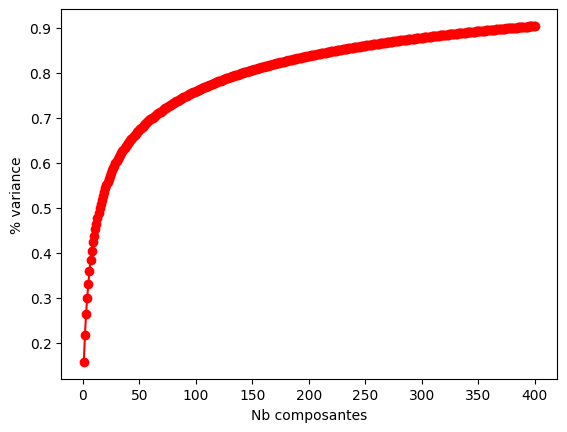

In [31]:
# Nombre de composante expliquant 95% de la variance
n_components = recherche_nb_composante(df_pca)

In [32]:
print(n_components)

399


In [33]:
# 325 composantes expliquent plus de 90% de la variance
#n_components = 325

#### 3.4.2. Réduction de dimension PCA

In [34]:
# Entrainement de l'algorithme
pca = PCA(k=n_components, inputCol='features_scaled', outputCol='vectors_pca')
model_pca = pca.fit(df_pca)

20/20 [==============================] - 231s 11s/step=====>      (14 + 2) / 16]


In [35]:
# Transformation des images sur les k premières composantes
df_reduit = model_pca.transform(df_pca)

In [36]:
# Visualisation du dataframe réduit
df_reduit.show()

23/02/23 14:04:05 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


20/20 [==============================] - 74s 4s/step                (0 + 1


+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|                path|            Classe|            features|    features_vectors|     features_scaled|         vectors_pca|
+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|s3a://oc-mb-fruit...|    Apple Golden 1|[1.3908136, 0.105...|[1.39081358909606...|[-0.4585866510895...|[10.0888665540643...|
|s3a://oc-mb-fruit...|    Apple Golden 1|[1.1243606, 1.209...|[1.12436056137084...|[-0.7558685133007...|[13.0278364687298...|
|s3a://oc-mb-fruit...|    Apple Golden 1|[0.36248526, 1.06...|[0.36248525977134...|[-1.6058934139962...|[11.8246161873753...|
|s3a://oc-mb-fruit...|    Apple Golden 1|[1.0520958, 1.028...|[1.05209577083587...|[-0.8364943995439...|[9.40815482006264...|
|s3a://oc-mb-fruit...|    Apple Golden 1|[0.8404527, 0.388...|[0.84045267105102...|[-1.0726247800665...|[13.2086149661

#### 3.4.3. Sauvegarde des données

Finalement, on sauvegarde les données pré-traitées et réduites au format parquet.

In [37]:
# Sauvegarde des données
df_reduit.write.mode("overwrite").parquet(f"{path_output}/resultats_features_parquet_docker")

23/02/23 14:09:15 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


20/20 [==============================] - 243s 12s/step


## 4. Test de classification (Bonus)

### 4.1. Préparation des données

**Seed**

In [38]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21

**Dataframe de travail**

In [39]:
# Chargement du dataframe sauvegardé en parquet
parquetFiles = f"{path_output}/resultats_features_parquet_docker/"

df_reduit = spark.read.parquet(parquetFiles)

In [40]:
# Conservation de la classe de l'image et des vecteurs pca
data = df_reduit[["Classe", "vectors_pca"]]

In [41]:
data.show(5)

+------------------+--------------------+
|            Classe|         vectors_pca|
+------------------+--------------------+
|    Apple Golden 1|[17.7831986774847...|
|    Apple Golden 1|[19.1825409301842...|
|Apple Red Yellow 1|[21.8540157137091...|
|    Apple Golden 1|[14.9590223993291...|
|    Apple Golden 1|[7.61593602112723...|
+------------------+--------------------+
only showing top 5 rows



**Encodage de la variable cible**

In [42]:
# Encodage de la variable cible : la classe de l'image acceptable par le modèle
indexer = StringIndexer(inputCol="Classe", outputCol="Classe_index")

# Fit the indexer to learn Classe/index pairs
indexerModel = indexer.fit(data)

# Append a new column with the index
data = indexerModel.transform(data)

In [43]:
data.show(10)

+------------------+--------------------+------------+
|            Classe|         vectors_pca|Classe_index|
+------------------+--------------------+------------+
|    Apple Golden 1|[17.7831986774847...|        13.0|
|    Apple Golden 1|[19.1825409301842...|        13.0|
|Apple Red Yellow 1|[21.8540157137091...|         6.0|
|    Apple Golden 1|[14.9590223993291...|        13.0|
|    Apple Golden 1|[7.61593602112723...|        13.0|
|    Apple Golden 1|[11.8499044028579...|        13.0|
|    Apple Golden 1|[3.25541272728802...|        13.0|
|    Apple Golden 1|[13.1831756451722...|        13.0|
|Apple Red Yellow 1|[15.8235284653867...|         6.0|
|Apple Red Yellow 1|[13.9317452277242...|         6.0|
+------------------+--------------------+------------+
only showing top 10 rows




[Stage 56:>                                                         (0 + 1) / 1]



**Découpage du jeu du train set en jeux d'entraînement et de validation**

In [44]:
# data splitting
(train_data, valid_data) = data.randomSplit([0.8, 0.2])

In [45]:
print("Nbre élément train_data : " + str(train_data.count()))
print("Nbre élément valid_data : " + str(valid_data.count()))

Nbre élément train_data : 8181


Nbre élément valid_data : 1975



[Stage 60:=============================>                            (2 + 2) / 4]



In [46]:
train_data.show(3)

+--------------+--------------------+------------+
|        Classe|         vectors_pca|Classe_index|
+--------------+--------------------+------------+
|Apple Braeburn|[5.42407259015119...|         1.0|
|Apple Braeburn|[6.13695916121848...|         1.0|
|Apple Braeburn|[8.28306107415651...|         1.0|
+--------------+--------------------+------------+
only showing top 3 rows



### 4.2. Modélisation Logistic Regression

***Modélisation Régression Logistique***

[Source](https://spark.apache.org/docs/latest/ml-classification-regression.html#multinomial-logistic-regression)

***Entraînement du modèle***

In [47]:
# Instanciation du modèle.
lr = LogisticRegression(labelCol="Classe_index", featuresCol="vectors_pca",
                        maxIter=5)

# Entraînement du modèle
lr_model = lr.fit(train_data)

23/02/23 14:31:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/23 14:31:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


***Prédictions***

In [48]:
# Make predictions.
lr_predictions = lr_model.transform(valid_data)

# Select example rows to display.
lr_predictions.select("prediction", "Classe_index").show(5)

+----------+------------+
|prediction|Classe_index|
+----------+------------+
|       1.0|         1.0|
|       1.0|         1.0|
|       1.0|         1.0|
|       1.0|         1.0|
|       1.0|         1.0|
+----------+------------+
only showing top 5 rows



***Évaluation du modèle***

In [49]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Classe_index", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print("Test Error = %g" % (1.0 - lr_accuracy))
print("Accuracy = %g " % lr_accuracy)

Test Error = 0
Accuracy = 1 



[Stage 73:=============================>                            (2 + 2) / 4]



***Informations sur le modèle***

In [50]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lr_model.coefficientMatrix))
print("Intercept: " + str(lr_model.interceptVector))

trainingSummary = lr_model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
DenseMatrix([[ 0.00807486,  0.00093297,  0.0113877 , ...,  0.04181633,
               0.1225972 , -0.07498887],
             [ 0.03205731,  0.00898669,  0.00366905, ...,  0.03149249,
               0.06003111, -0.02459186],
             [ 0.02272443,  0.01618705,  0.00707976, ..., -0.15501492,
              -0.02889036,  0.01895527],
             ...,
             [ 0.03373483,  0.00239208,  0.00039793, ..., -0.02069195,
              -0.11128819,  0.14101735],
             [ 0.00921943, -0.0060061 , -0.00470468, ..., -0.04104298,
              -0.07606165,  0.01429307],
             [-0.02172264, -0.06141798, -0.0311153 , ..., -0.03617463,
              -0.02826665, -0.04067397]])
Intercept: [0.3552784691672554,0.03792962523219951,0.04540531031241126,0.028519677833253303,0.061408066467469415,0.07803733985447447,0.01985723204517775,0.016422222630849092,-0.02776003078410383,-0.016134346122982517,-0.02877947380845544,-0.007774450602258859,0.07235045207897427,-0.01040214691

label 0: 0.0
label 1: 0.0
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
label 10: 0.0
label 11: 0.0
label 12: 0.0
label 13: 0.0
label 14: 0.0
label 15: 0.0
label 16: 0.0
label 17: 0.0
label 18: 0.0
label 19: 0.0
label 20: 0.0
True positive rate by label:
label 0: 1.0
label 1: 1.0
label 2: 1.0
label 3: 1.0
label 4: 1.0
label 5: 1.0
label 6: 1.0
label 7: 1.0
label 8: 1.0
label 9: 1.0
label 10: 1.0
label 11: 1.0
label 12: 1.0
label 13: 1.0
label 14: 1.0
label 15: 1.0
label 16: 1.0
label 17: 1.0
label 18: 1.0
label 19: 1.0
label 20: 1.0
Precision by label:
label 0: 1.0
label 1: 1.0
label 2: 1.0
label 3: 1.0
label 4: 1.0
label 5: 1.0
label 6: 1.0
label 7: 1.0
label 8: 1.0
label 9: 1.0
label 10: 1.0
label 11: 1.0
label 12: 1.0
label 13: 1.0
label 14: 1.0
label 15: 1.0
label 16: 1.0
label 17: 1.0
label 18: 1.0
label 19: 1.0
label 20: 1.0
Recall by label:
label 0: 1.0
label 1: 1.0
label 2: 1.0
label 3: 1.0
label 4: 1.0
label 5: 1.0
labe

### 4.3. Modélisation Decision Tree Classifier

***Modélisation Decision Tree Classifier***

[Source](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

***Entraînement du modèle***

In [51]:
# Instanciation du modèle.
dtc = DecisionTreeClassifier(labelCol="Classe_index", featuresCol="vectors_pca",
                             seed=seed)

# Entraînement du modèle
dtc_model = dtc.fit(train_data)

***Prédictions***

In [52]:
# Make predictions.
dtc_predictions = dtc_model.transform(valid_data)

# Select example rows to display.
dtc_predictions.select("prediction", "Classe_index").show(5)

+----------+------------+
|prediction|Classe_index|
+----------+------------+
|      18.0|         1.0|
|       1.0|         1.0|
|       1.0|         1.0|
|      12.0|         1.0|
|       1.0|         1.0|
+----------+------------+
only showing top 5 rows



***Évaluation du modèle***

In [53]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Classe_index", predictionCol="prediction", metricName="accuracy")
dtc_accuracy = evaluator.evaluate(dtc_predictions)
print("Test Error = %g" % (1.0 - dtc_accuracy))
print("Accuracy = %g " % dtc_accuracy)

Test Error = 0.420253
Accuracy = 0.579747 



[Stage 92:===========================================>              (3 + 1) / 4]



***Informations sur le modèle***

In [54]:
print(dtc_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_91461eac64d0, depth=5, numNodes=63, numClasses=21, numFeatures=399
  If (feature 0 <= -7.027327516535486)
   If (feature 1 <= 1.135409772212815)
    If (feature 5 <= 6.687913224009245)
     If (feature 9 <= -3.2561438137401324)
      If (feature 7 <= -0.7668402605863389)
       Predict: 14.0
      Else (feature 7 > -0.7668402605863389)
       Predict: 3.0
     Else (feature 9 > -3.2561438137401324)
      If (feature 5 <= -8.434090491073535)
       Predict: 17.0
      Else (feature 5 > -8.434090491073535)
       Predict: 20.0
    Else (feature 5 > 6.687913224009245)
     If (feature 12 <= -1.883080987563183)
      If (feature 1 <= -10.106259752404016)
       Predict: 20.0
      Else (feature 1 > -10.106259752404016)
       Predict: 3.0
     Else (feature 12 > -1.883080987563183)
      If (feature 2 <= -0.083835926085461)
       Predict: 8.0
      Else (feature 2 > -0.083835926085461)
       Predict: 7.0
   Else (feature 1 > 1.1

### 4.4. Modélisation Random Forest Classifier

***Modélisation Random Forest Classifier***

[Source](https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier)

***Entraînement du modèle***

In [55]:
# Instanciation du modèle.
rf = RandomForestClassifier(labelCol="Classe_index", featuresCol="vectors_pca", numTrees=20,
                             seed=seed)

# Entraînement du modèle
rf_model = rf.fit(train_data)

***Prédictions***

In [56]:
# Make predictions.
rf_predictions = rf_model.transform(valid_data)

# Select example rows to display.
rf_predictions.select("prediction", "Classe_index").show(5)

+----------+------------+
|prediction|Classe_index|
+----------+------------+
|       1.0|         1.0|
|       0.0|         1.0|
|       1.0|         1.0|
|       1.0|         1.0|
|       1.0|         1.0|
+----------+------------+
only showing top 5 rows



***Évaluation du modèle***

In [57]:
# Select (prediction, true label) and compute test error
rf_evaluator = MulticlassClassificationEvaluator(
    labelCol="Classe_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print("Test Error = %g" % (1.0 - rf_accuracy))
print("Accuracy = %g " % rf_accuracy)

Test Error = 0.113418
Accuracy = 0.886582 


***Matrice de confusion***

In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' #if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [63]:
lrmetrics = MulticlassMetrics(rf_predictions['Classe_index','prediction'].rdd)
cnf_matrix = lrmetrics.confusionMatrix()
print('[rf] Confusion de Matrix:\n', cnf_matrix.toArray())

[rf] Confusion de Matrix:
 [[135.   3.   0.   2.   4.   3.   0.   9.   0.   0.   0.   0.   0.   1.
    0.   8.   2.   0.   3.   0.   0.]
 [  2.  84.   0.   0.   5.   1.   3.   0.   0.   0.   0.   0.   1.   0.
    0.   3.   0.   0.   3.   0.   0.]
 [  0.   0.  88.   0.   0.   8.   0.   0.   0.   0.   0.   0.   4.   0.
    0.   1.   0.   0.   1.   0.   0.]
 [  0.   0.   6.  80.   0.   8.   0.   0.   0.   0.   0.   0.   1.   0.
    0.   2.   0.   0.   0.   2.   0.]
 [  0.   0.   0.   0.  60.   1.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   1.   0.   0.   1.   0.   0.]
 [  0.   3.   0.   0.   4.  45.   7.   0.   0.   2.   0.   0.   0.   1.
    0.   3.   0.   0.   3.   1.   0.]
 [  0.   2.   0.   0.   7.   1.  78.   0.   0.   0.   0.   0.   0.   0.
    0.   1.   0.   0.   2.   0.   0.]
 [  0.   0.   0.   0.   1.   2.   0. 100.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   4.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  91.   0.   0.   0.   0.   0.
    1.   0.   0.   0.

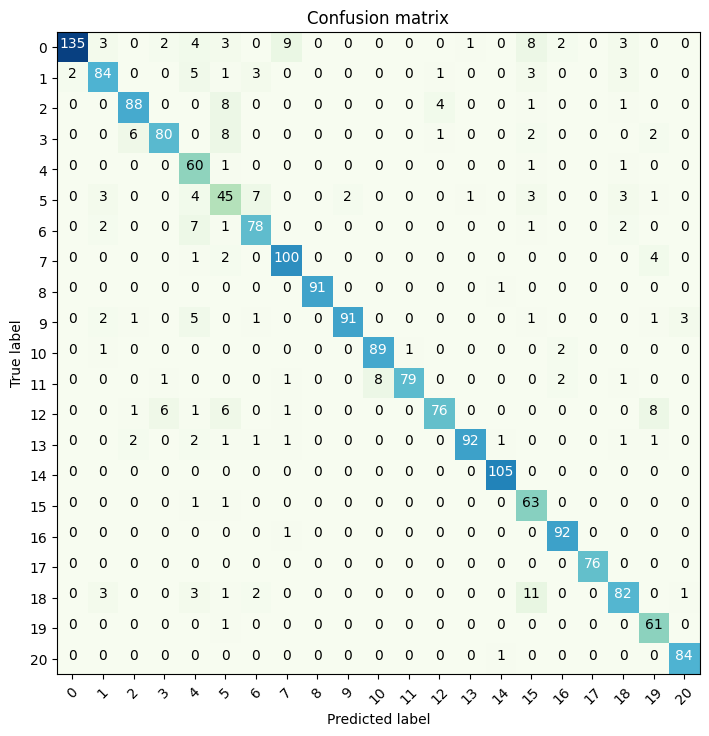

In [70]:
#sns.set_style("darkgrid")

plt.figure(figsize=(7,14))
plt.grid(False)

# call pre defined function
plot_confusion_matrix(cnf_matrix.toArray(), classes=range(len(cnf_matrix.toArray())))

***Informations sur le modèle***

In [61]:
print(rf_model.toDebugString)

RandomForestClassificationModel: uid=RandomForestClassifier_7fc18caafd4b, numTrees=20, numClasses=21, numFeatures=399
  Tree 0 (weight 1.0):
    If (feature 14 <= -6.591991289727208)
     If (feature 1 <= -15.311706488093229)
      If (feature 8 <= 9.134842177087092)
       If (feature 138 <= 0.09369978542007915)
        Predict: 20.0
       Else (feature 138 > 0.09369978542007915)
        Predict: 8.0
      Else (feature 8 > 9.134842177087092)
       Predict: 14.0
     Else (feature 1 > -15.311706488093229)
      If (feature 0 <= -19.167717281997906)
       If (feature 74 <= 3.694120329072828)
        Predict: 10.0
       Else (feature 74 > 3.694120329072828)
        Predict: 11.0
      Else (feature 0 > -19.167717281997906)
       If (feature 162 <= -2.190511134933095)
        Predict: 6.0
       Else (feature 162 > -2.190511134933095)
        If (feature 7 <= -0.29745123587264644)
         Predict: 16.0
        Else (feature 7 > -0.29745123587264644)
         Predict: 5.0
    Else (